In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Focal Loss for handling imbalanced classes
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return loss.mean()

# Hybrid Model with EfficientNet and ViT
class HybridModel1(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        self.fc = nn.Linear(1280 + 768, num_classes)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        return self.fc(features)

# Hybrid Model with ResNet and ViT
class HybridModel2(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        self.fc = nn.Linear(2048 + 768, num_classes)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        return self.fc(features)

# Ensemble Model
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
    
    def forward(self, x):
        pred1 = self.model1(x)
        pred2 = self.model2(x)
        return (pred1 + pred2) / 2  # Averaging predictions

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

# Training function with detailed stats printing
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50):
    best_test_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        test_accuracy = evaluate_model(model, test_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}%")

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), "new_best_ensemble_model.pth")
            print(f"🔹 Best model saved with Test Accuracy: {best_test_accuracy:.2f}%")

        scheduler.step()

# Initialize models
model1 = HybridModel1().to(device)
model2 = HybridModel2().to(device)
ensemble_model = EnsembleModel(model1, model2).to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(ensemble_model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
criterion = FocalLoss()

# Train
train_model(ensemble_model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/miniconda3/envs/tf-metal-fix/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:15<00:00,  1.01it/s]


Epoch 1/50 | Train Loss: 0.0419 | Train Acc: 80.46% | Test Acc: 49.48%
🔹 Best model saved with Test Accuracy: 49.48%


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:11<00:00,  1.08it/s]


Epoch 2/50 | Train Loss: 0.0246 | Train Acc: 86.48% | Test Acc: 84.90%
🔹 Best model saved with Test Accuracy: 84.90%


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:10<00:00,  1.09it/s]


Epoch 3/50 | Train Loss: 0.0174 | Train Acc: 89.41% | Test Acc: 84.90%


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:09<00:00,  1.11it/s]


Epoch 4/50 | Train Loss: 0.0155 | Train Acc: 90.55% | Test Acc: 94.27%
🔹 Best model saved with Test Accuracy: 94.27%


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:13<00:00,  1.04it/s]


Epoch 5/50 | Train Loss: 0.0153 | Train Acc: 92.02% | Test Acc: 92.71%


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:11<00:00,  1.08it/s]


Epoch 6/50 | Train Loss: 0.0116 | Train Acc: 93.81% | Test Acc: 91.15%


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:09<00:00,  1.11it/s]


Epoch 7/50 | Train Loss: 0.0077 | Train Acc: 96.42% | Test Acc: 94.27%


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:13<00:00,  1.05it/s]


Epoch 8/50 | Train Loss: 0.0053 | Train Acc: 97.23% | Test Acc: 92.19%


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:11<00:00,  1.07it/s]


Epoch 9/50 | Train Loss: 0.0051 | Train Acc: 98.21% | Test Acc: 93.75%


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:09<00:00,  1.11it/s]


Epoch 10/50 | Train Loss: 0.0040 | Train Acc: 97.88% | Test Acc: 94.27%


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:06<00:00,  1.16it/s]


Epoch 11/50 | Train Loss: 0.0064 | Train Acc: 96.42% | Test Acc: 92.71%


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:08<00:00,  1.12it/s]


Epoch 12/50 | Train Loss: 0.0032 | Train Acc: 98.05% | Test Acc: 94.27%


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:09<00:00,  1.11it/s]


Epoch 13/50 | Train Loss: 0.0054 | Train Acc: 97.23% | Test Acc: 94.27%


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:09<00:00,  1.11it/s]


Epoch 14/50 | Train Loss: 0.0055 | Train Acc: 96.58% | Test Acc: 94.27%


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:09<00:00,  1.11it/s]


Epoch 15/50 | Train Loss: 0.0063 | Train Acc: 96.58% | Test Acc: 94.27%


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:10<00:00,  1.10it/s]


Epoch 16/50 | Train Loss: 0.0095 | Train Acc: 95.28% | Test Acc: 92.19%


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [16:05<00:00, 12.54s/it]


Epoch 17/50 | Train Loss: 0.0099 | Train Acc: 94.14% | Test Acc: 92.19%


Epoch 18/50:  17%|████████████████████████████████                                                                                                                                                              | 13/77 [08:47<43:16, 40.56s/it]


KeyboardInterrupt: 

/Users/ramanathanswaminathan/miniconda3/envs/tf-metal-fix/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:23<00:00,  1.08s/it]


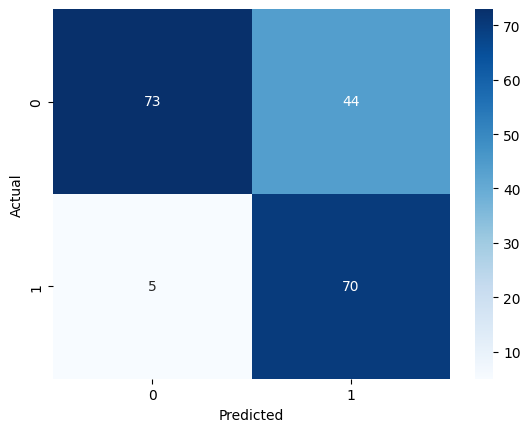

              precision    recall  f1-score   support

           0       0.94      0.62      0.75       117
           1       0.61      0.93      0.74        75

    accuracy                           0.74       192
   macro avg       0.77      0.78      0.74       192
weighted avg       0.81      0.74      0.75       192

✅ Saved Best Model at best_ensemble_model__.pth with Accuracy: 74.48%


Epoch 2/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 64/77 [01:01<00:12,  1.04it/s]


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import pandas as pd

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Focal Loss for handling imbalanced classes
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return loss.mean()

# Hybrid Model with ResNet and ViT
class HybridModel(nn.Module):
    def __init__(self, base_model, feature_dim, num_classes=2):
        super().__init__()
        self.cnn = base_model
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        
        self.fc = nn.Linear(feature_dim, 2048)  # Projection layer
        self.classifier = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        combined_features = torch.cat([cnn_features, vit_features], dim=-1)
        projected = self.fc(combined_features)
        return self.classifier(projected)

# Ensemble Model
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.beta = nn.Parameter(torch.tensor(0.5))
    
    def forward(self, x):
        pred1 = self.model1(x)
        pred2 = self.model2(x)
        return self.alpha * pred1 + self.beta * pred2

# Initialize models
model1 = HybridModel(models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1), 1280 + 768).to(device)
model2 = HybridModel(models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1), 2048 + 768).to(device)
ensemble_model = EnsembleModel(model1, model2).to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(ensemble_model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
criterion = FocalLoss()

# Training and Evaluation
# Training and Evaluation
train_losses, test_accuracies = [], []
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=100):
    best_test_accuracy = 0.0  # Track best accuracy
    best_model_path = "best_ensemble_model__.pth"  # File to save the best model

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        test_accuracy = evaluate_model(model, test_loader)
        
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        scheduler.step()

        # Save model if test accuracy improves
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ Saved Best Model at {best_model_path} with Accuracy: {best_test_accuracy:.2f}%")

    plot_results()

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    plot_confusion_matrix(all_labels, all_preds)
    print(classification_report(all_labels, all_preds))
    return 100 * np.mean(np.array(all_preds) == np.array(all_labels))

def plot_results():
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Train
train_model(ensemble_model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/pytorch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ramanathanswaminathan

Epoch [1/50] - Loss: 0.6824 - Train Acc: 76.87% - Test Loss: 0.9626 - Test Acc: 78.12%
Epoch [2/50] - Loss: 0.5067 - Train Acc: 81.27% - Test Loss: 0.4610 - Test Acc: 82.29%
Epoch [3/50] - Loss: 0.4973 - Train Acc: 81.43% - Test Loss: 0.4985 - Test Acc: 79.17%
Epoch [4/50] - Loss: 0.4484 - Train Acc: 85.34% - Test Loss: 0.5115 - Test Acc: 86.46%
Epoch [5/50] - Loss: 0.4101 - Train Acc: 88.76% - Test Loss: 0.4229 - Test Acc: 86.98%
Epoch [6/50] - Loss: 0.3802 - Train Acc: 89.09% - Test Loss: 0.3605 - Test Acc: 90.10%
Epoch [7/50] - Loss: 0.3764 - Train Acc: 91.04% - Test Loss: 0.4037 - Test Acc: 86.46%
Epoch [8/50] - Loss: 0.3765 - Train Acc: 92.02% - Test Loss: 0.4444 - Test Acc: 87.50%
Epoch [9/50] - Loss: 0.3686 - Train Acc: 89.90% - Test Loss: 0.4463 - Test Acc: 87.50%
Epoch [10/50] - Loss: 0.3255 - Train Acc: 92.83% - Test Loss: 0.4174 - Test Acc: 88.02%
Epoch [11/50] - Loss: 0.3678 - Train Acc: 91.04% - Test Loss: 0.4211 - Test Acc: 88.02%
Epoch [12/50] - Loss: 0.3570 - Train Acc:

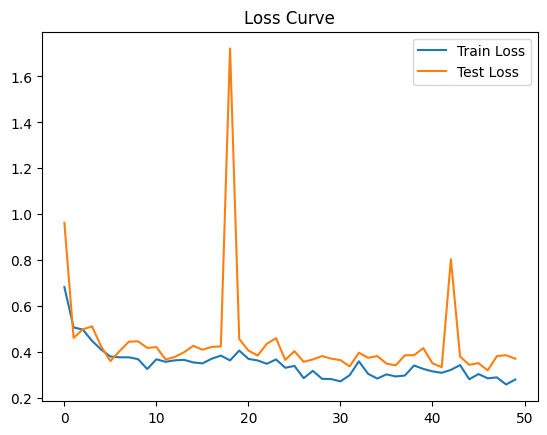

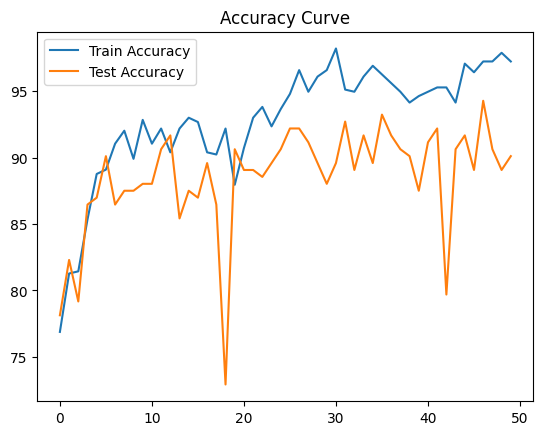

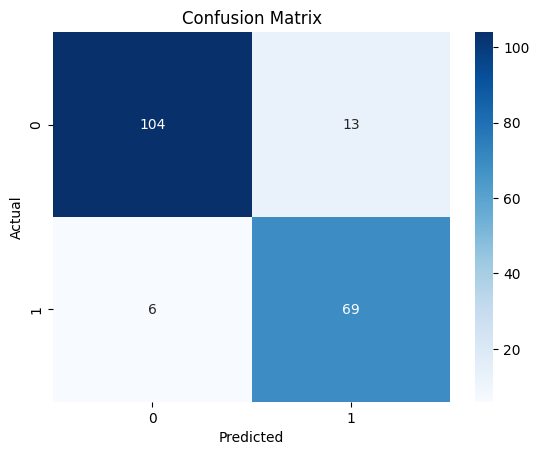

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       117
           1       0.84      0.92      0.88        75

    accuracy                           0.90       192
   macro avg       0.89      0.90      0.90       192
weighted avg       0.90      0.90      0.90       192



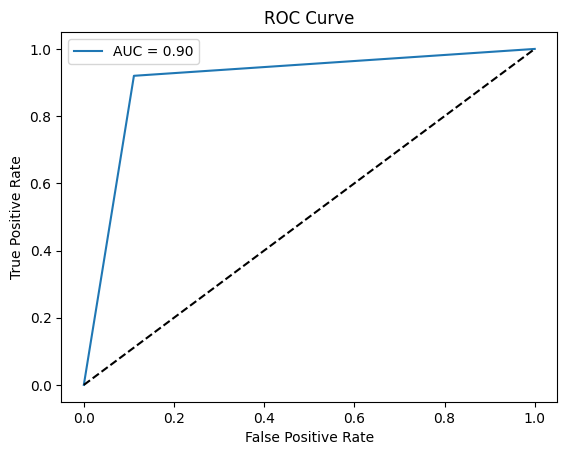

In [1]:
#ensemble updated 

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model 1: Hybrid Model with EfficientNet and ViT
class HybridModel1(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        
        self.cross_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, batch_first=True)
        
        self.attention_weights = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.fc = nn.Linear(feature_dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        attn_output, _ = self.cross_attention(fused_features.unsqueeze(1), fused_features.unsqueeze(1), fused_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)
        
        attention_scores = torch.sigmoid(self.attention_weights(attn_output))
        weighted_features = attn_output * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Model 2: Hybrid Model with ResNet and ViT
class HybridModel2(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.resnet150(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        self.projection = nn.Linear(512 + feature_dim, feature_dim)
        
        self.cross_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, batch_first=True)
        
        self.attention_weights = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.fc = nn.Linear(feature_dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        attn_output, _ = self.cross_attention(fused_features.unsqueeze(1), fused_features.unsqueeze(1), fused_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)
        
        attention_scores = torch.sigmoid(self.attention_weights(attn_output))
        weighted_features = attn_output * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

# Ensemble Model: Combine Predictions of Two Models
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
    
    def forward(self, x):
        # Get predictions from both models
        pred1 = self.model1(x)
        pred2 = self.model2(x)
        
        # Combine predictions: Averaging the outputs
        combined_pred = (pred1 + pred2) / 2
        return combined_pred

# Training function with Cyclical Learning Rate, Gradual Layer Freezing, and Label Smoothing
# Training function with saving the best model based on test accuracy
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=150):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    best_test_accuracy = 0.0
    best_model_state_dict = None
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        running_test_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_accuracy = correct_test / total_test * 100
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Loss: {avg_test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()

        # Save the model with the best test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_state_dict = model.state_dict()
            print(f"New best model with Test Acc: {best_test_accuracy:.2f}%")
    
    # Save the best model after training completes
    if best_model_state_dict is not None:
        torch.save(best_model_state_dict, "best_ensemble_model.pth")
        print("Best model saved with Test Accuracy: {:.2f}%".format(best_test_accuracy))
    
    # Plotting training and testing curves
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()
    
    plt.figure()
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    # Confusion Matrix and other metrics
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(classification_report(all_labels, all_preds))
    
    # ROC and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, np.array(all_preds))
    auc_score = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Initialize models
model1 = HybridModel1().to(device)
model2 = HybridModel2().to(device)

# Create ensemble model
ensemble_model = EnsembleModel(model1, model2).to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(ensemble_model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Train ensemble model
train_model(ensemble_model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/miniconda3/envs/tf-metal-fix/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/miniconda3/envs/tf-metal-fix/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/miniconda3/envs/tf-metal-fix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
 

Epoch [1/50] - Loss: 0.6503 - Train Acc: 76.22% - Test Loss: 0.3779 - Test Acc: 85.42%
Epoch [2/50] - Loss: 0.4688 - Train Acc: 82.74% - Test Loss: 0.3632 - Test Acc: 84.90%
Epoch [3/50] - Loss: 0.4640 - Train Acc: 85.18% - Test Loss: 0.4033 - Test Acc: 87.50%
Epoch [4/50] - Loss: 0.4225 - Train Acc: 84.85% - Test Loss: 0.4495 - Test Acc: 85.42%
Epoch [5/50] - Loss: 0.4165 - Train Acc: 87.79% - Test Loss: 0.2667 - Test Acc: 91.67%
Epoch [6/50] - Loss: 0.3277 - Train Acc: 88.11% - Test Loss: 0.3797 - Test Acc: 84.90%
Epoch [7/50] - Loss: 0.2883 - Train Acc: 92.02% - Test Loss: 0.6268 - Test Acc: 84.90%
Epoch [8/50] - Loss: 0.3316 - Train Acc: 91.69% - Test Loss: 0.9221 - Test Acc: 81.77%
Epoch [9/50] - Loss: 0.3624 - Train Acc: 91.53% - Test Loss: 0.4593 - Test Acc: 89.58%
Epoch [10/50] - Loss: 0.1694 - Train Acc: 95.28% - Test Loss: 0.4698 - Test Acc: 88.02%
Epoch [11/50] - Loss: 0.2117 - Train Acc: 95.60% - Test Loss: 0.5013 - Test Acc: 86.46%
Epoch [12/50] - Loss: 0.3218 - Train Acc:

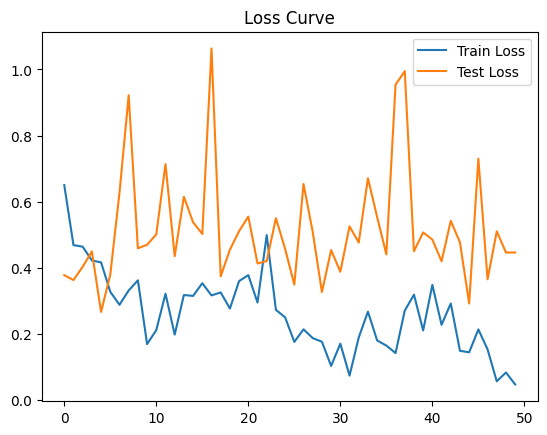

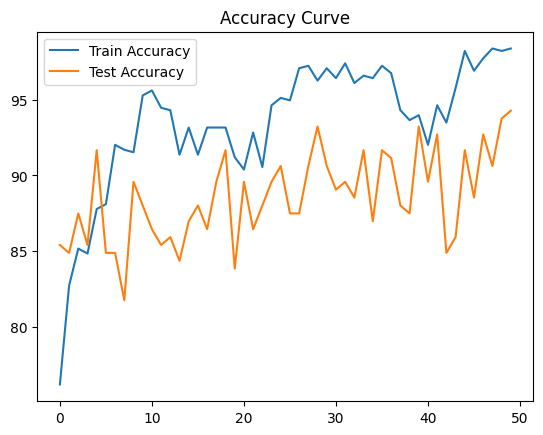

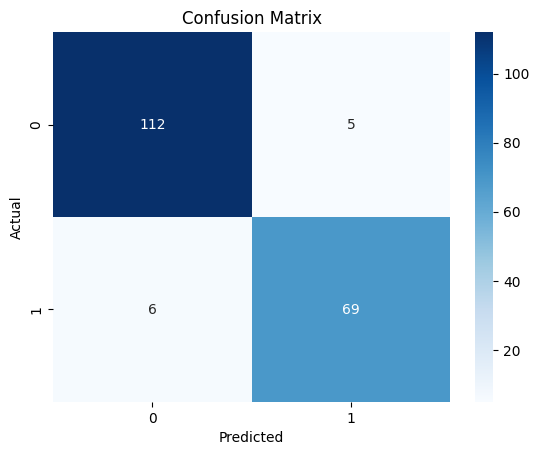

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       117
           1       0.93      0.92      0.93        75

    accuracy                           0.94       192
   macro avg       0.94      0.94      0.94       192
weighted avg       0.94      0.94      0.94       192



In [1]:
#heavily improvised 93pct saved with stats

#only concat no cross-attntion

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hybrid Model with Advanced Feature Fusion
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super().__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        
        self.cross_attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=8, batch_first=True)
        
        self.attention_weights = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.fc = nn.Linear(feature_dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        attn_output, _ = self.cross_attention(fused_features.unsqueeze(1), fused_features.unsqueeze(1), fused_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)
        
        attention_scores = torch.sigmoid(self.attention_weights(attn_output))
        weighted_features = attn_output * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        return self.fc(weighted_features)

import os

# Training function with model checkpoint saving
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50, checkpoint_dir="checkpoints"):
    # Create directory for checkpoints if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        running_test_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_accuracy = correct_test / total_test * 100
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Loss: {avg_test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()
        
        # Save checkpoint at the end of every epoch
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
    
    # Final model save
    torch.save(model.state_dict(), "final_model.pth")
    
    # Plot loss and accuracy curves
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()
    
    plt.figure()
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(classification_report(all_labels, all_preds))

# Initialize and train model
model = HybridModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


/Users/ramanathanswaminathan/miniconda3/envs/tf-metal-fix/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ramanathanswaminathan/miniconda3/envs/tf-metal-fix/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramanathanswaminathan/miniconda3/envs/tf-metal-fix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
 

Epoch [1/50] - Loss: 0.6999 - Train Acc: 77.85% - Test Loss: 0.4246 - Test Acc: 82.81%
Best model saved with Test Acc: 82.81%
Epoch [2/50] - Loss: 0.3301 - Train Acc: 86.81% - Test Loss: 0.3778 - Test Acc: 83.33%
Best model saved with Test Acc: 83.33%
Epoch [3/50] - Loss: 0.3719 - Train Acc: 86.81% - Test Loss: 0.4165 - Test Acc: 86.46%
Best model saved with Test Acc: 86.46%
Epoch [4/50] - Loss: 0.2028 - Train Acc: 91.86% - Test Loss: 0.2660 - Test Acc: 87.50%
Best model saved with Test Acc: 87.50%
Epoch [5/50] - Loss: 0.2752 - Train Acc: 91.86% - Test Loss: 0.4051 - Test Acc: 87.50%
Epoch [6/50] - Loss: 0.1788 - Train Acc: 93.65% - Test Loss: 0.3897 - Test Acc: 88.54%
Best model saved with Test Acc: 88.54%
Epoch [7/50] - Loss: 0.2266 - Train Acc: 92.67% - Test Loss: 0.3469 - Test Acc: 88.54%
Epoch [8/50] - Loss: 0.1611 - Train Acc: 94.46% - Test Loss: 0.3573 - Test Acc: 89.06%
Best model saved with Test Acc: 89.06%
Epoch [9/50] - Loss: 0.1984 - Train Acc: 94.14% - Test Loss: 0.3281 - 

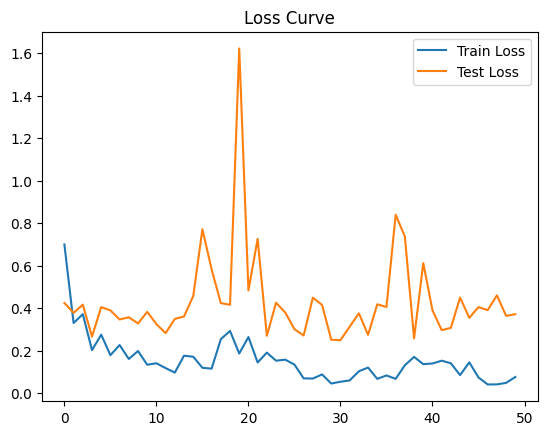

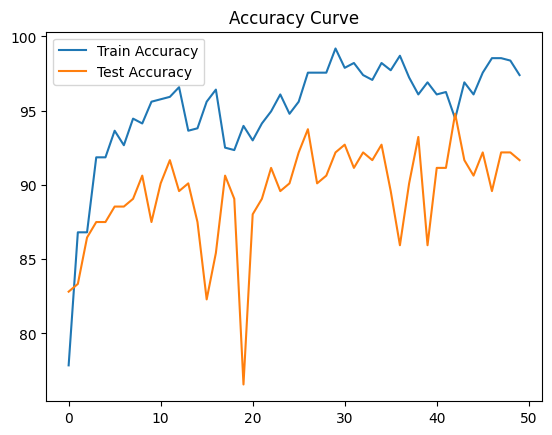

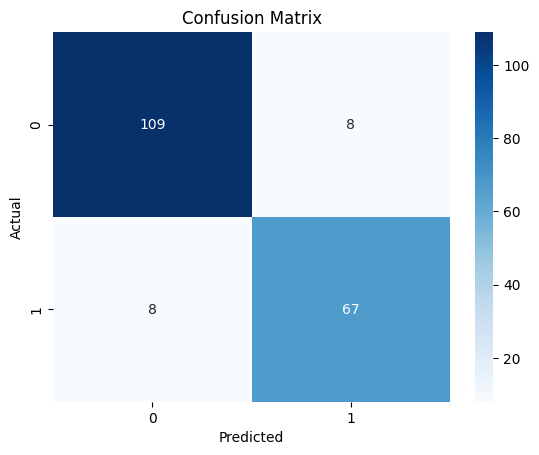

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       117
           1       0.89      0.89      0.89        75

    accuracy                           0.92       192
   macro avg       0.91      0.91      0.91       192
weighted avg       0.92      0.92      0.92       192



In [1]:
#cross attn 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from transformers import ViTModel
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Cross-Attention Module
class CrossAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super(CrossAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
    
    def forward(self, query, key_value):
        # Shape: (batch_size, seq_len=1, embed_dim)
        attn_output, attn_weights = self.attn(query, key_value, key_value)
        return attn_output, attn_weights

# Hybrid Model with Cross-Attention
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super(HybridModel, self).__init__()
        self.cnn = models.efficientnet_b0(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # remove last classification layer
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        
        # Cross-Attention setup
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.cross_attention = CrossAttention(embed_dim=feature_dim)
        
        self.attention_weights = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.fc = nn.Linear(feature_dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)  # (B, 1280)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]  # (B, 768)
        
        # Concatenate CNN and ViT features
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        # Cross-Attention
        attn_output, attn_weights = self.cross_attention(fused_features.unsqueeze(1), fused_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)
        
        # Attention score and weighted features
        attention_scores = torch.sigmoid(self.attention_weights(attn_output))
        weighted_features = attn_output * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        
        return self.fc(weighted_features), attn_weights

# Training function with model checkpoint saving
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

# Corrected Training function with model checkpoint saving
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device, epochs=50, checkpoint_dir="checkpoints_new"):
    # Create directory for checkpoints if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    best_test_accuracy = 0.0
    best_model_state_dict = None
    
    # Initialize lists for storing loss and accuracy values
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(inputs)  # UNPACK outputs
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = correct_train / total_train * 100
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)
        
        # Testing Phase
        model.eval()
        correct_test, total_test = 0, 0
        running_test_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs)  # UNPACK outputs
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                correct_test += (outputs.argmax(1) == labels).sum().item()
                total_test += labels.size(0)
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_accuracy = correct_test / total_test * 100
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Loss: {avg_test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")
        scheduler.step()
        
        # Save best model
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_state_dict = model.state_dict()
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
            }, os.path.join(checkpoint_dir, "best_model.pth"))
            print(f"Best model saved with Test Acc: {test_accuracy:.2f}%")
        
        # Save checkpoint at the end of every epoch
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
    
    # Final model save (last checkpoint)
    torch.save(model.state_dict(), "final_model.pth")
    
    # Plot loss and accuracy curves
    plt.figure()
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()
    
    plt.figure()
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(classification_report(all_labels, all_preds))
        

# Initialize and train model
model = HybridModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, device)


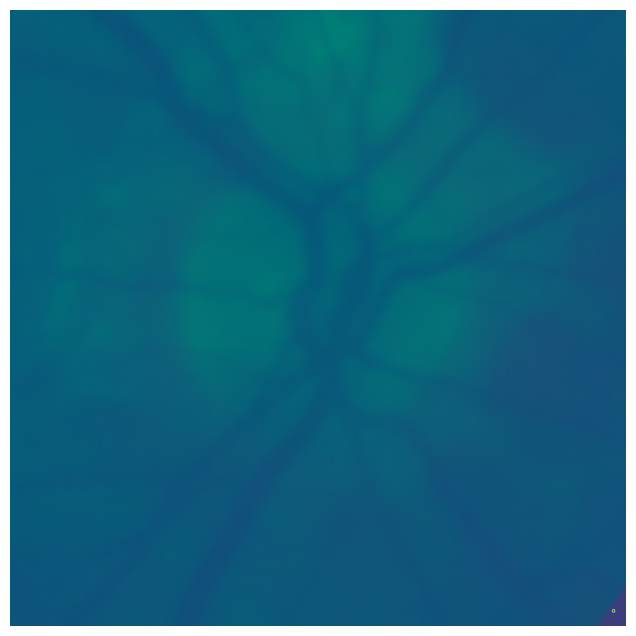

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTModel

# Define CrossAttention module
class CrossAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super(CrossAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
    
    def forward(self, query, key_value):
        attn_output, attn_weights = self.attn(query, key_value, key_value)
        return attn_output, attn_weights

# Define HybridModel
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super(HybridModel, self).__init__()
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # remove last classification layer
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.cross_attention = CrossAttention(embed_dim=feature_dim)
        
        self.attention_weights = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.fc = nn.Linear(feature_dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)  # (B, 1280)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]  # (B, 768)
        
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        attn_output, attn_weights = self.cross_attention(fused_features.unsqueeze(1), fused_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)
        
        attention_scores = torch.sigmoid(self.attention_weights(attn_output))
        weighted_features = attn_output * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        
        return self.fc(weighted_features), attn_weights

# ----------------------------

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = HybridModel().to(device)

# Load saved model weights
checkpoint = torch.load("final_model.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# ----------------------------

# Define Grad-CAM
def generate_gradcam(model, input_image, target_class):
    input_image = input_image.requires_grad_()
    output, _ = model(input_image)
    loss = output[:, target_class].sum()
    loss.backward()
    
    gradients = input_image.grad  # Gradient wrt input
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    activations = input_image.squeeze(0).detach()
    
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

# Visualize Grad-CAM
# Visualize Grad-CAM
def visualize_gradcam(input_tensor, heatmap):
    img = input_tensor.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # overlay heatmap
    plt.axis('off')
    plt.show()

# ----------------------------

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset paths
train_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Training"
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load dataset
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ----------------------------

# Run inference on 1 image
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Only pick 1 image
    input_image = inputs[0].unsqueeze(0)
    label = labels[0]
    
    # Forward pass
    output, _ = model(input_image)
    
    # Get predicted class
    pred_class = torch.argmax(output[0])
    
    # Grad-CAM
    gradcam_map = generate_gradcam(model, input_image, target_class=pred_class.item())
    
    # Visualize
    visualize_gradcam(input_image, gradcam_map)
    
    break  # visualize only one image


In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTModel

# Define CrossAttention module
class CrossAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super(CrossAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
    
    def forward(self, query, key_value):
        attn_output, attn_weights = self.attn(query, key_value, key_value)
        return attn_output, attn_weights

# Define HybridModel
class HybridModel(nn.Module):
    def __init__(self, feature_dim=768, num_classes=2):
        super(HybridModel, self).__init__()
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # remove last classification layer
        
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224", add_pooling_layer=False)
        
        self.projection = nn.Linear(1280 + feature_dim, feature_dim)
        self.cross_attention = CrossAttention(embed_dim=feature_dim)
        
        self.attention_weights = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        self.fc = nn.Linear(feature_dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(feature_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        cnn_features = self.cnn(x).flatten(1)  # (B, 1280)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]  # (B, 768)
        
        features = torch.cat([cnn_features, vit_features], dim=-1)
        fused_features = self.projection(features)
        
        attn_output, attn_weights = self.cross_attention(fused_features.unsqueeze(1), fused_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)
        
        attention_scores = torch.sigmoid(self.attention_weights(attn_output))
        weighted_features = attn_output * attention_scores
        
        weighted_features = self.batch_norm(weighted_features)
        weighted_features = self.dropout(weighted_features)
        
        return self.fc(weighted_features), attn_weights

# ----------------------------

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = HybridModel().to(device)

# Load saved model weights
checkpoint = torch.load("final_model.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# ----------------------------

# Define Grad-CAM
def generate_gradcam(model, input_image, target_class):
    input_image = input_image.requires_grad_()
    output, _ = model(input_image)
    loss = output[:, target_class].sum()
    loss.backward()
    
    gradients = input_image.grad  # Gradient wrt input
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    activations = input_image.squeeze(0).detach()
    
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    
    if np.max(heatmap) != 0:  # Avoid division by zero
        heatmap /= np.max(heatmap)
    else:
        print("Warning: Heatmap max value is zero, skipping normalization.")

    
    return heatmap

# Save Grad-CAM image
def save_gradcam_image(input_tensor, heatmap, output_path):
    img = input_tensor.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize image to 0-1 range
    
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # overlay heatmap
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# ----------------------------

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset paths
test_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/Testing"

# Load dataset
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ----------------------------

# Directory to save Grad-CAM images
save_dir = "/Users/ramanathanswaminathan/Downloads/glaucoma_exhaustive/acrima+drishti/GradCam"

# Run inference and Grad-CAM on all images in the test set
for idx, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    
    for i in range(inputs.size(0)):  # Iterate through each image in the batch
        input_image = inputs[i].unsqueeze(0)
        label = labels[i]
        
        # Forward pass
        output, _ = model(input_image)
        
        # Get predicted class
        pred_class = torch.argmax(output[0])
        
        # Grad-CAM
        gradcam_map = generate_gradcam(model, input_image, target_class=pred_class.item())
        
        # Save the Grad-CAM image
        image_name = f"gradcam_{idx * inputs.size(0) + i}.png"
        output_path = os.path.join(save_dir, image_name)
        save_gradcam_image(input_image, gradcam_map, output_path)
    
    # Optionally break after processing a batch, if you want to process a limited number
    # break  # Uncomment to stop after the first batch
